# 农作物分类可视化分析——以玉米和大豆为例

In [ ]:
# %%!pip install geemap pandas matplotlib

In [1]:
import ee
import geemap
ee.Initialize()
geemap.set_proxy(port="7890") # Colab 中运行时不需要

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1 提取研究区域所有 Landsat 影像

### 1.1 定义研究区域并可视化

In [3]:
TIGER = ee.FeatureCollection('TIGER/2018/Counties')
region = ee.Feature(TIGER.filter(ee.Filter.eq('STATEFP', '17')) \
   .filter(ee.Filter.eq('NAME', 'McLean')) \
   .first()).geometry()
Map = geemap.Map()
Map.centerObject(region)
Map.addLayer(region, {'color': 'red'}, 'McLean County')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

### 1.2 加载 Landsat 7 和 8 L2 级影像

In [4]:
landsat7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

### 1.3 重命名 Landsat 波段

In [5]:
def renameL7(img):
    img = img.rename([
        'BLUE', 'GREEN', 'RED', 'NIR',
        'SWIR1', 'SWIR2', 'TEMP1',
        'ATMOS_OPACITY', 'QA_CLOUD',
        'ATRAN', 'CDIST',
        'DRAD', 'EMIS', 'EMSD', 'QA', 'TRAD', 'URAD',
        'QA_PIXEL', 'QA_RADSAT'
    ])
    return img

def renameL8(img):
    img = img.rename([
        'AEROS',
        'BLUE', 'GREEN', 'RED', 'NIR',
        'SWIR1', 'SWIR2', 'TEMP1',
        'QA_AEROSOL',
        'ATRAN', 'CDIST',
        'DRAD', 'EMIS', 'EMSD', 'QA', 'TRAD', 'URAD',
        'QA_PIXEL', 'QA_RADSAT'
    ])
    return img

### 1.4 去云掩膜

In [6]:
def addMask(img):
    # Bit 0: Fill
    # Bit 1: Dilated Cloud
    # Bit 2: Cirrus (high confidence) (L8) or unused (L7)
    # Bit 3: Cloud
    # Bit 4: Cloud Shadow
    # Bit 5: Snow
    # Bit 6: Clear
    #        0: Cloud or Dilated Cloud bits are set
    #        1: Cloud and Dilated Cloud bits are not set
    # Bit 7: Water
    clear = img.select('QA_PIXEL').bitwiseAnd(64).neq(0)
    clear = clear.updateMask(clear).rename(['pxqa_clear'])

    water = img.select('QA_PIXEL').bitwiseAnd(128).neq(0)
    water = water.updateMask(water).rename(['pxqa_water'])

    cloud_shadow = img.select('QA_PIXEL').bitwiseAnd(16).neq(0)
    cloud_shadow = cloud_shadow.updateMask(cloud_shadow).rename([
       'pxqa_cloudshadow'
    ])

    snow = img.select('QA_PIXEL').bitwiseAnd(32).neq(0)
    snow = snow.updateMask(snow).rename(['pxqa_snow'])

    masks = ee.Image.cat([
       clear, water, cloud_shadow, snow
    ])
    return img.addBands(masks)

def maskQAClear(img):
    return img.updateMask(img.select('pxqa_clear'))

### 1.5 计算并添加 GCVI 波段

In [7]:
def addGCVI(img):
    gcvi = img.expression(
        '(nir / green) - 1',
        {
            'nir': img.select('NIR'),
            'green': img.select('GREEN')
        }).select([0], ['GCVI'])
    return ee.Image.cat([img, gcvi])

### 1.6 筛选处理数据

In [8]:
start_date = '2020-01-01'
end_date = '2020-12-31'

# 筛选出起止日期间研究区域的Landsat 7 和 8 数据
landsat7coll = landsat7.filterBounds(region) \
    .filterDate(start_date, end_date) \
    .map(renameL7)

landsat8coll = landsat8.filterBounds(region) \
    .filterDate(start_date, end_date) \
    .map(renameL8)

In [9]:
# 融合筛选处理后的 Landsat 7 和 8 影像集合 
landsat = landsat7coll.merge(landsat8coll).sort('system:time_start')

# 屏蔽不清晰的像素，添加 GCVI 和 time 变量
landsat = landsat.map(addMask).map(maskQAClear).map(addGCVI)

### 1.7 图表可视化

In [10]:
point = ee.Geometry.Point([-88.81417685576481, 40.579804398254005])

In [11]:
# 提取该点上每张影像的 GCVI 值
# 并返回一个包含 GCVI 值和时间属性的Feature
def get_gcvi_and_date(image):
    # 获取某一点上的 GCVI 值
    gcvi = image.select('GCVI').reduceRegion(ee.Reducer.first(), point)
    # 获取影像的日期，使用ee.Date()方法，并格式化为YYYY-MM-dd
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    # 返回一个包含 GCVI 值和时间属性的要素
    return ee.Feature(point, {'date': date, 'gcvi': gcvi})

# 使用ee.ImageCollection.map()方法来对影像集合中每个影像应用上面定义的函数
# map()函数返回的是一个ee.ComputedObject类型的对象
# 需要将结果转化为ee.FeatureCollection
gcvi_val = ee.FeatureCollection(landsat.map(get_gcvi_and_date))

In [12]:
# 将要素集合类型的数据导出成表格
df = geemap.ee_to_pandas(gcvi_val)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# 使用apply()方法来获取每个字典中的GCVI值
df['gcvi'] = df['gcvi'].apply(lambda x: x['GCVI'])
# 将gcvi列中的空值设置为NaN
df['gcvi'] = df['gcvi'].replace('', np.nan)
GCVI_output = './output/gcvi_chart.xlsx'
df.to_excel(GCVI_output, index=False)

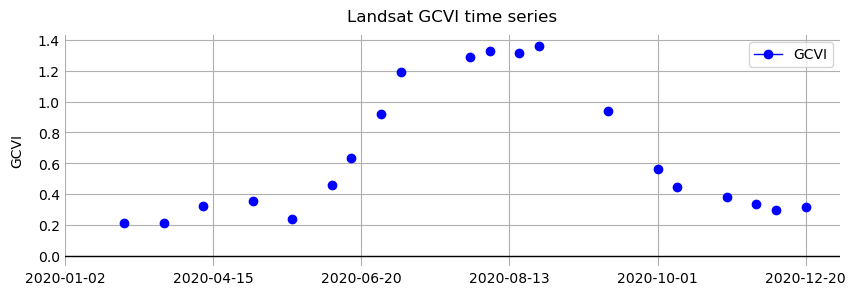

In [13]:
# 读取表格数据绘制折线图
GCVI_df = pd.read_excel(GCVI_output)

plt.figure(figsize=(10, 3))
GCVI_df['date'] = GCVI_df['date'].dt.strftime('%Y-%m-%d')
# 将gcvi列中的空值设置为NaN
GCVI_df['gcvi'] = GCVI_df['gcvi'].replace('', np.nan)

# 绘制折线图，使用日期作为x轴，GCVI值作为y轴
plt.plot(GCVI_df['date'], GCVI_df['gcvi'], 'b-', marker='o', linewidth=1.0)
plt.ylabel('GCVI', labelpad=10)
plt.xticks(np.arange(0, len(GCVI_df), 15))
plt.title('Landsat GCVI time series', pad=10)
# 网格线
plt.grid(True)
# 去除绘制边框
plt.box(False)
# 通过修改x轴样式来实现底部边框效果
plt.axhline(0, color='black', linewidth=1.0)
# 将x轴和y轴修改样式，不显示刻度位置，只显示刻度数字
plt.tick_params(axis='both', length=0)
# 添加折线图例
plt.legend(['GCVI'])

# 保存图形为一个png文件，分辨率为300dpi，要放在图像绘制之前
out_file = "./output/Landsat_GCVI_time_series.png"
plt.savefig(out_file, dpi=300)
plt.show()

### 1.8 获取作物类型数据集

In [14]:
cdl = ee.Image('USDA/NASS/CDL/2020').select(['cropland'])
Map.addLayer(cdl.clip(region), {}, 'CDL 2020')
Map

Map(center=[40.51926422440161, -88.86431136556666], controls=(WidgetControl(options=['position', 'transparent_…

## 2 向 Landsat 影像添加进行谐波回归后的波段

### 2.1 为图像添加时间波段

In [15]:
def addTimeUnit(image, refdate):
   date = image.date()
   dyear = date.difference(refdate, 'year')
   t = image.select(0).multiply(0).add(dyear).select([0], ['t']).float()
   imageplus = image.addBands(t)
   return imageplus

### 2.2 向图像添加谐波基波段

In [16]:
import math

def addHarmonics(image, omega, refdate):
    image = addTimeUnit(image, refdate)
    timeRadians = image.select('t').multiply(2 * math.pi * omega)
    timeRadians2 = image.select('t').multiply(4 * math.pi * omega)

    return image.addBands(timeRadians.cos().rename('cos')) \
        .addBands(timeRadians.sin().rename('sin')) \
        .addBands(timeRadians2.cos().rename('cos2')) \
        .addBands(timeRadians2.sin().rename('sin2')) \
        .addBands(timeRadians.divide(timeRadians).rename('constant'))

In [17]:
omega = 1
def use_addHarmonics(image):
    return addHarmonics(image, omega, start_date)
landsatPlus = landsat.map(use_addHarmonics)

## 3 在每个 Landsat 像素拟合一个调和回归

### 3.1 图像上运行线性回归函数

In [18]:
def arrayimgHarmonicRegr(harmonicColl, dependent, independents):
    independents = ee.List(independents)
    dependent = ee.String(dependent)

    regression = harmonicColl.select(independents.add(dependent)) \
        .reduce(ee.Reducer.linearRegression(independents.length(), 1))
    return regression

### 3.2 提取和重命名回归系数

In [19]:
def imageHarmonicRegr(harmonicColl, dependent, independents):
    hregr = arrayimgHarmonicRegr(harmonicColl, dependent, independents)
    independents = ee.List(independents)
    dependent = ee.String(dependent)

    def func_qur(b):
        return dependent.cat(ee.String('_')).cat(ee.String(b))

    newNames = independents.map(func_qur)
    imgCoeffs = hregr.select('coefficients') \
        .arrayProject([0]) \
        .arrayFlatten([independents]) \
        .select(independents, newNames)
    return imgCoeffs

In [20]:
def getHarmonicCoeffs(harmonicColl, bands, independents):
    def use_imageHarmonicRegr(band):
        return imageHarmonicRegr(harmonicColl, band, independents)
    coefficients = ee.ImageCollection.fromImages(bands.map(use_imageHarmonicRegr))
    return coefficients.toBands()

### 3.3 应用函数得到含有谐波波段的图像

In [21]:
bands = ee.List(['NIR', 'SWIR1', 'SWIR2', 'GCVI'])
independents = ee.List(['constant', 'cos', 'sin', 'cos2', 'sin2'])
harmonics = getHarmonicCoeffs(landsatPlus, bands, independents)

harmonics = harmonics.clip(region)
harmonics = harmonics.multiply(10000).toInt32()

In [22]:
nowBands = harmonics.bandNames().remove('cropland').remove('system:index')
nowBands.getInfo()

['0_NIR_constant',
 '0_NIR_cos',
 '0_NIR_sin',
 '0_NIR_cos2',
 '0_NIR_sin2',
 '1_SWIR1_constant',
 '1_SWIR1_cos',
 '1_SWIR1_sin',
 '1_SWIR1_cos2',
 '1_SWIR1_sin2',
 '2_SWIR2_constant',
 '2_SWIR2_cos',
 '2_SWIR2_sin',
 '2_SWIR2_cos2',
 '2_SWIR2_sin2',
 '3_GCVI_constant',
 '3_GCVI_cos',
 '3_GCVI_sin',
 '3_GCVI_cos2',
 '3_GCVI_sin2']

### 3.4 计算 GCVI 拟合值

In [23]:
gcviHarmonicCoefficients = harmonics.select([
    '3_GCVI_constant',
    '3_GCVI_cos',
    '3_GCVI_sin',
    '3_GCVI_cos2',
    '3_GCVI_sin2'
]).divide(10000)

def func_pkm(image):
    return image.addBands(image.select(independents) \
            .multiply(gcviHarmonicCoefficients) \
            .reduce('sum') \
            .rename('fitted'))
fittedHarmonic = landsatPlus.map(func_pkm)

### 3.5 图表可视化

In [24]:
# 提取每张影像该点的 GCVI 值及其拟合值
# 并返回一个包含 GCVI 及其拟合值和时间属性的Feature
def get_gcvi_fitted(image):
    # 获取某一点上的 GCVI 值
    gcvi = image.select('GCVI').reduceRegion(ee.Reducer.mean(), point, scale=30)
    # 获取某一点上的 GCVI 拟合值
    gcvi_fitted = image.select('fitted').reduceRegion(ee.Reducer.mean(), point, scale=30)
    # 获取影像的日期，使用ee.Date()方法，并格式化为YYYY-MM-dd
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    # 返回一个包含 GCVI 值和时间属性的要素
    return ee.Feature(point, {'date': date, 'gcvi': gcvi, 'gcvi_fitted': gcvi_fitted})

# 使用ee.ImageCollection.map()方法来对影像集合中每个影像应用上面定义的函数
# map()函数返回的是一个ee.ComputedObject类型的对象
# 需要将结果转化为ee.FeatureCollection
gcvi_fitted_val = ee.FeatureCollection(fittedHarmonic.map(get_gcvi_fitted))

In [25]:
df = geemap.ee_to_pandas(gcvi_fitted_val)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# 使用apply()方法来获取每个字典中的GCVI值
df['gcvi'] = df['gcvi'].apply(lambda x: x['GCVI'])
df['gcvi_fitted'] = df['gcvi_fitted'].apply(lambda x: x['fitted'])
GCVI_fitted_output = './output/gcvi_fitted_chart.xlsx'
df.to_excel(GCVI_fitted_output, index=False)

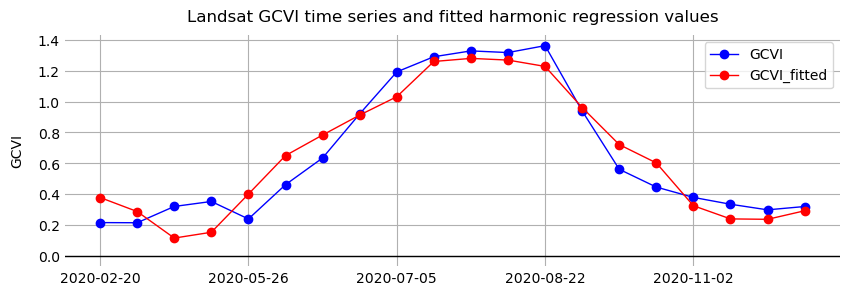

In [26]:
GCVI_fitted_df = pd.read_excel(GCVI_fitted_output)

plt.figure(figsize=(10, 3))
GCVI_fitted_df['date'] = GCVI_fitted_df['date'].dt.strftime('%Y-%m-%d')

# 删除缺失值一行
GCVI_fitted_df = GCVI_fitted_df.dropna()

# 为了让折线图在空值处断开，需要将空值替换为np.nan
# GCVI_fitted_df['gcvi'] = GCVI_fitted_df['gcvi'].replace('', np.nan)
# GCVI_fitted_df['gcvi_fitted'] = GCVI_fitted_df['gcvi_fitted'].replace('', np.nan)


# 绘制折线图，使用日期作为x轴，GCVI值作为y轴
plt.plot(GCVI_fitted_df['date'], GCVI_fitted_df['gcvi'], 'b-', marker='o', linewidth=1.0)
plt.plot(GCVI_fitted_df['date'], GCVI_fitted_df['gcvi_fitted'], 'r-', marker='o', linewidth=1.0)

plt.ylabel('GCVI', labelpad=10)
# 限制x轴显示
plt.xticks(np.arange(0, len(GCVI_fitted_df), 4))
plt.title('Landsat GCVI time series and fitted harmonic regression values', pad=10)
# 网格线
plt.grid(True)
# 去除绘制边框
plt.box(False)
# 通过修改x轴样式来实现底部边框效果
plt.axhline(0, color='black', linewidth=1.0)
# 将x轴和y轴修改样式，不显示刻度位置，只显示刻度数字
plt.tick_params(axis='both', length=0)
# 添加折线图例
plt.legend(['GCVI', 'GCVI_fitted'])

# 保存图形为一个png文件，分辨率为300dpi，要放在图像绘制之前
out_file = "./output/Landsat_GCVI_fitted_time_series.png"
plt.savefig(out_file, dpi=300)
plt.show()

### 3.6 在地图上可视化调和系数

In [27]:
# 地图可视化 GCVI 
visImage = ee.Image.cat([
   harmonics.select('3_GCVI_cos').divide(7000).add(0.6),
   harmonics.select('3_GCVI_sin').divide(7000).add(0.5),
   harmonics.select('3_GCVI_constant').divide(7000).subtract(0.6)
])

Map.addLayer(visImage,{
   'min': -0.5,
   'max': 0.5
}, '调和系数假彩色图像')
Map

Map(center=[40.51926422440161, -88.86431136556666], controls=(WidgetControl(options=['position', 'transparent_…

## 4 随机森林分类农作物类型

### 4.1 定义随机森林分类器

In [28]:
rf = ee.Classifier.smileRandomForest(**{
   'numberOfTrees': 50,
   'minLeafPopulation': 10,
})

### 4.2 将CDL转换为3类频带并加入谐波

In [29]:
harmonicsPlus = ee.Image.cat([harmonics, cdl])

cornSoyOther = harmonicsPlus.select('cropland').eq(1) \
		.add(harmonicsPlus.select('cropland').eq(5).multiply(2))
dataset = ee.Image.cat([harmonicsPlus.select(nowBands), cornSoyOther])

### 4.3 采样训练点并训练模型

In [30]:
train_points = dataset.sample(region, 30, None, None, 100, 0)
model = rf.train(train_points, 'cropland', nowBands)
# 训练集精度及其误差矩阵
trainCM = model.confusionMatrix()
print('训练集总体精度: ', trainCM.accuracy().getInfo())
print('训练集误差矩阵: ')
trainCM

训练集总体精度:  0.9
训练集误差矩阵: 


### 4.4 采样测试点并对其应用模型

In [31]:
test_points = dataset.sample(region, 30, None, None, 50, 1)
tested = test_points.classify(model)
# 在测试集上计算混淆矩阵和准确率
testAccuracy = tested.errorMatrix('cropland', 'classification')
print('测试集总体精度: ', testAccuracy.accuracy().getInfo())
print('测试集误差矩阵: ')
testAccuracy

测试集总体精度:  0.76
测试集误差矩阵: 


### 4.5 将模型应用于整个研究区域

In [32]:
regionClassified = harmonicsPlus.select(nowBands).classify(model)
predPalette = ['gray', 'yellow', 'green']
Map.addLayer(regionClassified, {
   'min': 0,
   'max': 2,
   'palette': predPalette
}, '分类器预测分类')
Map

Map(center=[40.51926422440161, -88.86431136556666], controls=(WidgetControl(options=['position', 'transparent_…

### 4.6 预测结果对比

In [33]:
Map.addLayer(regionClassified.eq(cornSoyOther), {
   'min': 0,
   'max': 1
}, '分类一致性对比')
Map

Map(center=[40.51926422440161, -88.86431136556666], controls=(WidgetControl(options=['position', 'transparent_…